### Statistical analysis ###

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import tools.data_reader_apd as dr_a
import tools.data_reader_wesad as dr_w
import tools.data_reader_popane as dr_p
import tools.display_tools as dt
import train

c:\Users\zhoux\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

In [6]:
# LOAD FEATURES AND LABELS
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)

threshold = "fixed"

# APD
phases = dr_a.Phases.PHASES_LIST
apd_label_type = "Anxiety"
x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
x = pd.concat([x, y], axis=1)

apd_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    apd_metric_dfs[phases[i]] = phase_df

# WESAD
phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"
x, y = train.Train_WESAD.get_wesad_data(metrics, phases, verbose=False, label_type=wesad_label_type, normalize=False, threshold=threshold)
x = pd.concat([x, y], axis=1)

wesad_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    wesad_metric_dfs[phases[i]] = phase_df

# POPANE
study = "Study1"
phases = dr_p.Study1.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_1 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_1[phases[i]] = phase_df

study = "Study2"
phases = dr_p.Study2.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_2 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_2[phases[i]] = phase_df

study = "Study3"
phases = dr_p.Study3.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_3 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_3[phases[i]] = phase_df

study = "Study4"
phases = dr_p.Study4.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_4 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_4[phases[i]] = phase_df

study = "Study5"
phases = dr_p.Study5.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_5 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_5[phases[i]] = phase_df

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [5]:
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)


statistics = {
    "mean": np.nanmean, 
    "median": np.nanmedian, 
    "std": np.nanstd, 
    "var": np.nanvar
}

print("DATASET: APD " + "-"*30)
apd_metric_stats = []
for phase in list(apd_metric_dfs.keys()):
    # print(f"APD PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = apd_metric_dfs[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        apd_metric_stats.append(stat_df)

apd_metric_stats = pd.concat(apd_metric_stats, axis=0).reset_index(drop=True)
print(apd_metric_stats)
print(f"APD LABEL COUNTS: {apd_metric_stats['label'].value_counts()}")


print("DATASET: WESAD " + "-"*30)
wesad_metric_stats = []
for phase in list(wesad_metric_dfs.keys()):
    # print(f"WESAD PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = wesad_metric_dfs[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        wesad_metric_stats.append(stat_df)

wesad_metric_stats = pd.concat(wesad_metric_stats, axis=0).reset_index(drop=True)
print(wesad_metric_stats)
print(f"WESAD LABEL COUNTS: {wesad_metric_stats['label'].value_counts()}")


print("DATASET: POPANE STUDY 1 " + "-"*30)
popane_metric_stats_1 = []
for phase in list(popane_metric_dfs_1.keys()):
    print(f"POPANE STUDY 1 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_1[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_1.append(stat_df)

popane_metric_stats_1 = pd.concat(popane_metric_stats_1, axis=0).reset_index(drop=True)
print(popane_metric_stats_1)
print(f"POPANE 1 LABEL COUNTS: {popane_metric_stats_1['label'].value_counts()}")


print("DATASET: POPANE STUDY 2 " + "-"*30)
popane_metric_stats_2 = []
for phase in list(popane_metric_dfs_2.keys()):
    print(f"POPANE STUDY 2 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_2[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_2.append(stat_df)

popane_metric_stats_2 = pd.concat(popane_metric_stats_2, axis=0).reset_index(drop=True)
print(popane_metric_stats_2)
print(f"POPANE 2 LABEL COUNTS: {popane_metric_stats_2['label'].value_counts()}")


print("DATASET: POPANE STUDY 3 " + "-"*30)
popane_metric_stats_3 = []
for phase in list(popane_metric_dfs_3.keys()):
    # print(f"POPANE STUDY 3 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_3[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_3.append(stat_df)

popane_metric_stats_3 = pd.concat(popane_metric_stats_3, axis=0).reset_index(drop=True)
print(popane_metric_stats_3)
print(f"POPANE 3 LABEL COUNTS: {popane_metric_stats_3['label'].value_counts()}")


print("DATASET: POPANE STUDY 4 " + "-"*30)
popane_metric_stats_4 = []
for phase in list(popane_metric_dfs_4.keys()):
    # print(f"POPANE STUDY 4 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_4[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_4.append(stat_df)

popane_metric_stats_4 = pd.concat(popane_metric_stats_4, axis=0).reset_index(drop=True)
print(popane_metric_stats_4)
print(f"POPANE 4 LABEL COUNTS: {popane_metric_stats_4['label'].value_counts()}")


print("DATASET: POPANE STUDY 5 " + "-"*30)
popane_metric_stats_5 = []
for phase in list(popane_metric_dfs_5.keys()):
    # print(f"POPANE STUDY 5 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_5[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_5.append(stat_df)

popane_metric_stats_5 = pd.concat(popane_metric_stats_5, axis=0).reset_index(drop=True)
print(popane_metric_stats_5)
print(f"POPANE 5 LABEL COUNTS: {popane_metric_stats_5['label'].value_counts()}")



DATASET: APD ------------------------------
    phaseId statistic  label         bpm         rmssd     hf_rr     lf_rr  \
0         0      mean      0  100.283081     80.999911  4.325165  0.473771   
1         0      mean      1  102.372377     86.448383  1.237388  0.063352   
2         0    median      0   89.446221     30.309991  1.028780  0.027562   
3         0    median      1   92.227049     35.309606  0.779546  0.003832   
4         0       std      0   26.466959    110.282832  7.900233  1.251504   
..      ...       ...    ...         ...           ...       ...       ...   
67        8    median      1   91.288783     32.935896  0.711038  0.005171   
68        8       std      0   30.567117    105.933209  1.399068  1.163623   
69        8       std      1   27.254246     99.461832  1.064948  0.150627   
70        8       var      0  934.348653  11221.844681  1.957391  1.354018   
71        8       var      1  742.793922   9892.656089  1.134115  0.022688   

             ibi   

In [76]:
# VISUALIZING LABELS

for i, phase in enumerate(list(apd_metric_dfs.keys())):
    phase_df = apd_metric_stats[apd_metric_stats["phaseId"] == i].reset_index(drop=True)
    print(phase_df)

   phaseId statistic  label         bpm         rmssd      hf_rr     lf_rr  \
0        0      mean      0  100.283081     80.999911   4.325165  0.473771   
1        0      mean      1  102.372377     86.448383   1.237388  0.063352   
2        0    median      0   89.446221     30.309991   1.028780  0.027562   
3        0    median      1   92.227049     35.309606   0.779546  0.003832   
4        0       std      0   26.466959    110.282832   7.900233  1.251504   
5        0       std      1   27.961476     99.338354   1.402664  0.217977   
6        0       var      0  700.499925  12162.302928  62.413687  1.566262   
7        0       var      1  781.844137   9868.108619   1.967466  0.047514   

            ibi         sdnn  mean_SCL   SCR_rate  
0    638.711731    77.437290  0.664083  52.333333  
1    634.505066   108.373735  0.569901  48.396825  
2    671.152735    56.710173  0.643274  51.333333  
3    639.900816   106.083306  0.445712  46.952381  
4    148.234577    57.332960  0.23689

Base ------------------------------


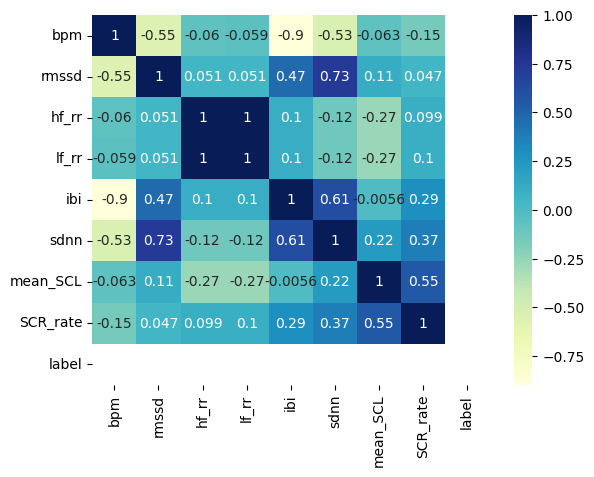

TSST ------------------------------


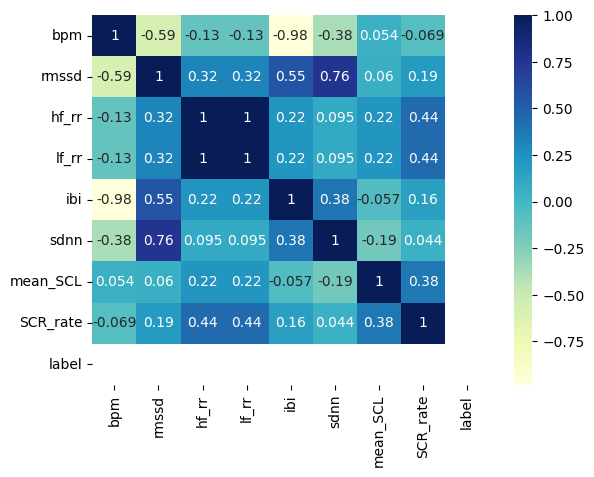

Medi_1 ------------------------------


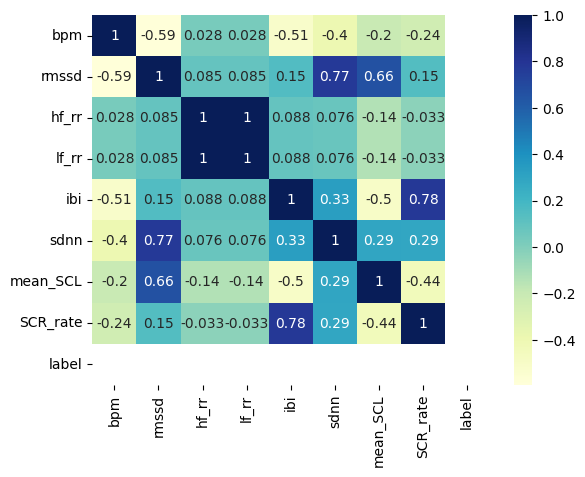

Fun ------------------------------


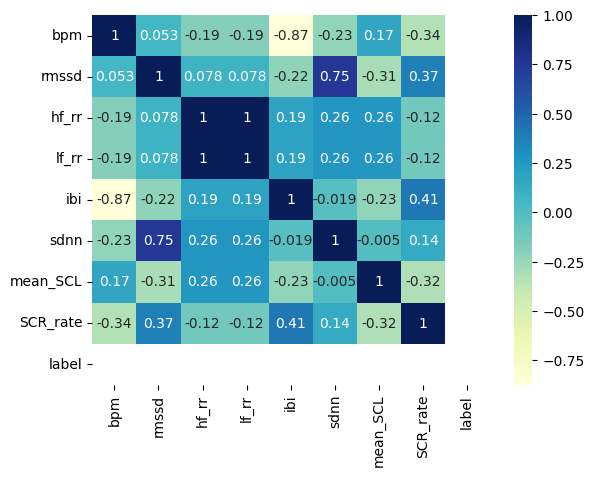

Medi_2 ------------------------------


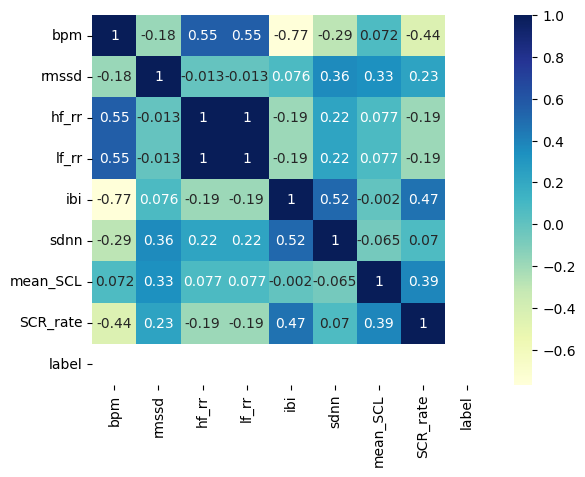

In [29]:
# VISUALIZING FEATURES -- correlation between mean of all features for each phase 
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)
import seaborn as sb

# phases = dr_a.Phases.PHASES_LIST
# apd_label_type = "Anxiety"
# threshold = "fixed"

# for i, phase in enumerate(phases):
#     print(f"{phase} " + "-"*30)
#     x, y = train.Train_APD.get_apd_data_ranking(metrics, [phase], verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
#     x = pd.concat([x, y], axis=1)
#     heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True)
#     plt.show()


phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"
threshold = "fixed"

for i, phase in enumerate(phases):
    print(f"{phase} " + "-"*30)
    x, y = train.Train_WESAD.get_wesad_data(metrics, [phase], verbose=False, label_type=wesad_label_type, normalize=True, threshold=threshold)
    x = pd.concat([x, y], axis=1)
    heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True)
    plt.show()